In [126]:
# Load bag files
import matplotlib.pyplot as plt
import sys, rospy, rosbag, os
import numpy as np

splines = []

for _, _, files in os.walk("splines"):
    for file in files:
        bag = rosbag.Bag("splines/" + file)
        for topic, msg, t in bag.read_messages(topics=['stats']):
            splines.append(msg)
        bag.close()
        print("Loaded ROS bag file from %s." % file)

Loaded ROS bag file from spline_0.bag.
Loaded ROS bag file from spline_1.bag.
Loaded ROS bag file from spline_2.bag.


The trajectories look as follows:
![Trajectories](https://dl.dropboxusercontent.com/u/17489929/Studium/Jobs/RESL/SMAP/smap_trajectories.png)

# MAE Evolution (All Voxels)

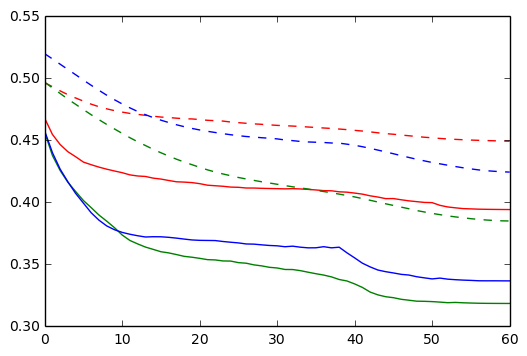

In [127]:
%matplotlib inline
colors = ["r", "g", "b"]
#self.axis_fullError.set_title('Mean Absolute Error (MAE) Evolution over all Voxels')
for i, spline in enumerate(splines):
    beliefName = 'Spline #{} - SMAP'.format(i)
    logOddsName = 'Spline #{} - Log Odds'.format(i)
    plt.plot(spline.errorEvolutionBelief, label=beliefName, c=colors[i%len(colors)])
    plt.plot(spline.errorEvolutionLogOdds, label=logOddsName, linestyle='dashed', c=colors[i%len(colors)])
#plt.legend()

# Reachability Evolution

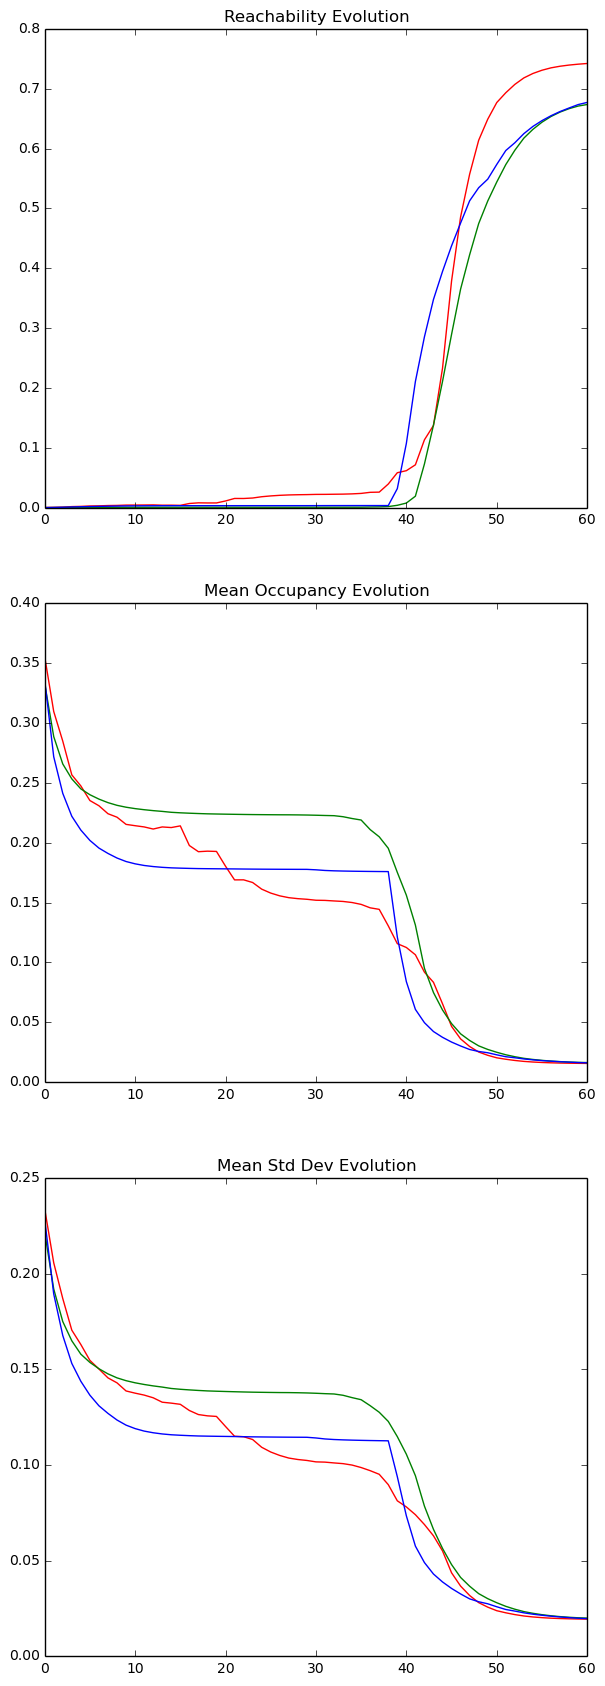

In [128]:
%matplotlib inline
plt.figure(figsize=(7,21))
sub = plt.subplot(311)
sub.set_title("Reachability Evolution")
#self.axis_fullError.set_title('Mean Absolute Error (MAE) Evolution over all Voxels')
for i, spline in enumerate(splines):
    beliefName = 'Spline #{} - SMAP'.format(i)
    logOddsName = 'Spline #{} - Log Odds'.format(i)
    reachabilityBelief = np.array(spline.trajectoryOccupanciesBelief)
    reachabilityBelief = reachabilityBelief.reshape(-1, spline.trajectoryVoxels)
    ones = np.ones(reachabilityBelief.shape)
    reachabilityBelief = ones - reachabilityBelief
    reachabilityBelief = np.prod(reachabilityBelief, axis=1)
    
    
    
    sub.plot(reachabilityBelief, label=beliefName, c=colors[i%len(colors)])
    #plt.plot(spline.errorEvolutionLogOdds, label=logOddsName, linestyle='dashed', c=colors[i%len(colors)])
#plt.legend()

sub = plt.subplot(312)
sub.set_title("Mean Occupancy Evolution")
for i, spline in enumerate(splines):
    beliefName = 'Spline #{} - SMAP'.format(i)
    logOddsName = 'Spline #{} - Log Odds'.format(i)
    mean = np.array(spline.trajectoryOccupanciesBelief)
    mean = mean.reshape(-1, spline.trajectoryVoxels)    
    
    sub.plot(np.mean(mean, axis=1), label=beliefName, c=colors[i%len(colors)])
    
sub = plt.subplot(313)
sub.set_title("Mean Std Dev Evolution")
for i, spline in enumerate(splines):
    beliefName = 'Spline #{} - SMAP'.format(i)
    logOddsName = 'Spline #{} - Log Odds'.format(i)
    stddev = np.array(spline.trajectoryStdDevsBelief)
    stddev = stddev.reshape(-1, spline.trajectoryVoxels)    
    
    sub.plot(np.mean(stddev, axis=1), label=beliefName, c=colors[i%len(colors)])

# Cost Function $\mu \cdot \sigma$

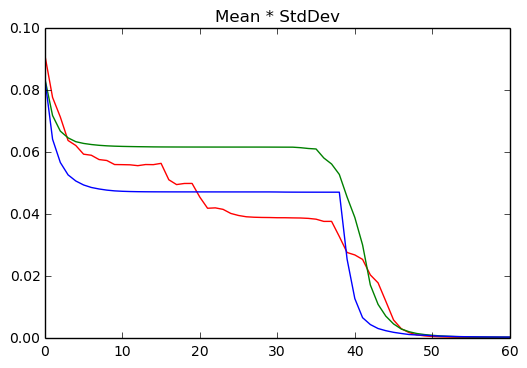

In [129]:
%matplotlib inline
plt.title("Mean * StdDev")
#self.axis_fullError.set_title('Mean Absolute Error (MAE) Evolution over all Voxels')
for i, spline in enumerate(splines):
    beliefName = 'Spline #{} - SMAP'.format(i)
    logOddsName = 'Spline #{} - Log Odds'.format(i)
    mean = np.array(spline.trajectoryOccupanciesBelief)
    mean = mean.reshape(-1, spline.trajectoryVoxels)
    stddev = np.array(spline.trajectoryStdDevsBelief)
    stddev = stddev.reshape(-1, spline.trajectoryVoxels)
    cost = np.multiply(mean, stddev)
    cost = np.mean(cost, axis=1)   
    
    
    plt.plot(cost, label=beliefName, c=colors[i%len(colors)])

# Cost Function $\frac{\mu}{\sigma^2}$

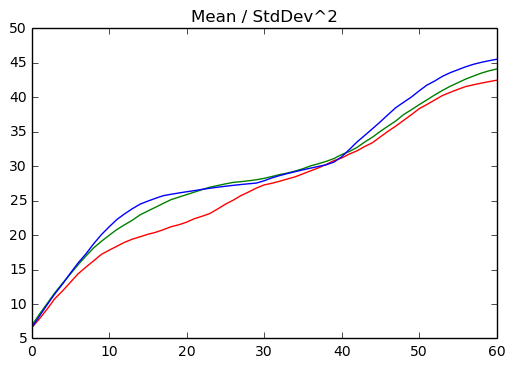

In [142]:
%matplotlib inline
plt.title("Mean / StdDev^2")
#self.axis_fullError.set_title('Mean Absolute Error (MAE) Evolution over all Voxels')
for i, spline in enumerate(splines):
    beliefName = 'Spline #{} - SMAP'.format(i)
    logOddsName = 'Spline #{} - Log Odds'.format(i)
    mean = np.array(spline.trajectoryOccupanciesBelief)
    mean = mean.reshape(-1, spline.trajectoryVoxels)
    stddev = np.array(spline.trajectoryStdDevsBelief)
    stddev = stddev.reshape(-1, spline.trajectoryVoxels)
    cost = np.divide(mean, np.square(stddev))
    cost = np.mean(cost, axis=1)   
    
    
    plt.plot(cost, label=beliefName, c=colors[i%len(colors)])

# Cost Function $\frac{1-\mu}{\sigma^2}$

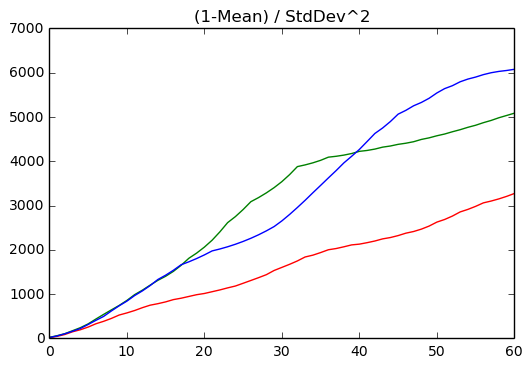

In [145]:
%matplotlib inline
plt.title("(1-Mean) / StdDev^2")
#self.axis_fullError.set_title('Mean Absolute Error (MAE) Evolution over all Voxels')
for i, spline in enumerate(splines):
    beliefName = 'Spline #{} - SMAP'.format(i)
    logOddsName = 'Spline #{} - Log Odds'.format(i)
    mean = np.array(spline.trajectoryOccupanciesBelief)
    mean = mean.reshape(-1, spline.trajectoryVoxels)
    stddev = np.array(spline.trajectoryStdDevsBelief)
    stddev = stddev.reshape(-1, spline.trajectoryVoxels)
    cost = np.divide(1-mean, np.square(stddev))
    cost = np.mean(cost, axis=1)   
    
    
    plt.plot(cost, label=beliefName, c=colors[i%len(colors)])

In [153]:
import requests
import plotly.plotly as py
from plotly.tools import FigureFactory as FF 

data_matrix = []
data_matrix.append([''] + list(map(lambda i: "Trajectory %i" % i, range(len(splines)))))

reachabilities = ["Reachability"]
cost2 = ["Cost function $\\frac{\\mu}{\\sigma^2}$"]
cost3 = ["Cost function $\\frac{1-\\mu}{\\sigma^2}$"]
for i, spline in enumerate(splines):
    beliefName = 'Spline #{} - SMAP'.format(i)
    logOddsName = 'Spline #{} - Log Odds'.format(i)
    mean = np.array(spline.trajectoryOccupanciesBelief[-spline.trajectoryVoxels:])
    stddev = np.array(spline.trajectoryStdDevsBelief[-spline.trajectoryVoxels:])
    ones = np.ones(mean.shape)
    reachabilityBelief = ones - reachabilityBelief
    reachabilityBelief = np.prod(reachabilityBelief)
    reachabilities.append(reachabilityBelief)
    
    c2 = np.divide(mean, np.square(stddev))
    c2 = np.mean(c2)
    cost2.append(c2)
    
    c3 = np.divide(1-mean, np.square(stddev))
    c3 = np.mean(c3)
    cost3.append(c3)

data_matrix.append(reachabilities)
data_matrix.append(cost2)
data_matrix.append(cost3)
table = FF.create_table(data_matrix)
py.iplot(table, filename='simple_table')

/usr/local/lib/python2.7/dist-packages/urllib3/util/ssl_.py:132: InsecurePlatformWarning:

A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings



High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~eric-heiden/0 or inside your plot.ly account where it is named 'simple_table'
